# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors.
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model.
1. Learn how to deploy and use a text model on CAIP. 



## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [63]:
PROJECT = "qwiklabs-gcp-04-3886b4f1d70f"  # Replace with your PROJECT
BUCKET = PROJECT 
REGION = "us-central1"
#REGION = "us-central1-a"
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [4]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,url,title,score
0,https://postgresml.org/user_guides/transformer...,Show HN: PostgresML integrates Hugging Face to...,14
1,http://www.jvmhost.com/articles/memory-usage-c...,JVM Host - Memory usage comparison of Java App...,15
2,http://quoterobot.com,Show HN: QuoteRobot Rebuilt In Python/Flask/Mo...,18
3,http://shoutfast.com,Show HN: I made this: ShoutFast,32
4,http://bribe.io/,Bribe developers to fix bugs,38
5,http://chronicle.com/article/Coursera-Throws-a...,John Doerr: Coursera 'Could Be Big The Way Goo...,49
6,http://legacy.earlham.edu/~peters/writing/infa...,A Crash Course in the Mathematics Of Infinite ...,51
7,http://blog.kaelig.fr/post/51078221503/apple-i...,"Apple Is Using Sass, And They’re Doing It Wrong",71
8,https://bugs.ruby-lang.org/issues/8339,Generational Garbage Collection for Ruby 2.1,85
9,http://jackwmorgan.com/ok-glass,"Ok, glass – new Google Glass concepts",89


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [5]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,source,num_articles
0,github,123624
1,medium,111783
2,youtube,89728
3,nytimes,64827
4,blogspot,53082
...,...,...
95,nextplatform,2359
96,anandtech,2351
97,politico,2340
98,extremetech,2333


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,show hn make a header that reacts well to scr...,github
1,show hn js object mapper generator from db sc...,github
2,show hn webrtc nuts and bolts a holistic way...,github
3,create a static website and api on aws with on...,github
4,top to bottom setup and update scripts for an ...,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 236186 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

github        123624
nytimes        64827
techcrunch     47735
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [10]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [12]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        554
nytimes       256
techcrunch    190
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [13]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [14]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.6.5


In [15]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [16]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [17]:
ls ./data/

titles_full.csv  titles_sample.csv


In [18]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,bubbles carry a lot of weight texting anxiety...,nytimes
1,manage and clone peer-to-peer git repositories,github
2,implementation of linear regression from scrat...,github
3,show hn play with the soar cognitive architec...,github
4,western digital to aquire sandisk for $19b,techcrunch


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [19]:
titles_df.source.value_counts()

github        123624
nytimes        64827
techcrunch     47735
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [20]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [21]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [22]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [23]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [24]:
sources_train.value_counts()

github        117477
nytimes        61578
techcrunch     45321
Name: source, dtype: int64

In [25]:
sources_valid.value_counts()

github        6147
nytimes       3249
techcrunch    2414
Name: source, dtype: int64

Now let's create the features and labels we will feed our models with:

In [26]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [27]:
X_train[:3]

array(['bubbles carry a lot of weight  texting anxiety caused by little bubbles',
       'manage and clone peer-to-peer git repositories',
       'implementation of linear regression from scratch  with mathematical explanation '],
      dtype=object)

In [28]:
Y_train[:3]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

### Lab Task 1a: Import NNLM TF Hub module into `KerasLayer`

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [42]:
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(NNLM,output_shape=[50],input_shape=[],dtype=tf.string,trainable=True)

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

### Lab Task 1b: Use module to encode a sentence string

In [43]:
nnlm_module(tf.constant(["Google launches Vertex AI studio with powerful GenAI solutions"]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.02928968,  0.02335368, -0.00064366,  0.06151358, -0.22016475,
         0.05342099, -0.04935883,  0.08486777, -0.28438264, -0.16686937,
        -0.24844673,  0.34798905, -0.00861346,  0.00403938, -0.03893653,
         0.10178465,  0.05948808, -0.02465991,  0.11077152,  0.14485517,
         0.16098678, -0.2886244 ,  0.01952722, -0.3617748 , -0.10029785,
        -0.22225016, -0.05442449,  0.12239899,  0.14702535, -0.01641686,
         0.17741327, -0.3590697 , -0.2677475 ,  0.0732125 ,  0.26816586,
        -0.22195724,  0.21005808,  0.04851168,  0.03855968,  0.1280834 ,
         0.16938531, -0.19166923,  0.01828709,  0.11427643, -0.13644916,
        -0.42604846, -0.06370549, -0.08848773,  0.16302323,  0.21423677]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

### Lab Task 1c: Import Swivel TF Hub module into `KerasLayer`

In [44]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(SWIVEL,output_shape=[20],input_shape=[],dtype=tf.string, trainable = True)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

### Lab Task 1d: Use module to encode a sentence string

In [45]:
swivel_module(tf.constant(["Google launches Vertex AI studio with powerful GenAI solutions"]))

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 1.7967603 , -0.657184  ,  2.302422  ,  0.88547295, -0.3904152 ,
         1.8036313 ,  1.0605485 , -0.98912144, -1.0045353 , -1.9771061 ,
         0.1842709 ,  0.8973949 , -1.3352464 ,  0.7461118 , -0.20254777,
        -1.2998042 ,  0.8366689 ,  0.40330625,  0.93288827, -0.6920166 ]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

### Lab Task 2: Incorporate a pre-trained TF Hub module as first layer of Keras Sequential Model

In [47]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module,
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [48]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=TensorBoard(model_dir),
    )
    return history

## Training NNLM

In [49]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [50]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

2024-01-29 14:49:05.226849: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-01-29 14:49:05.227068: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-01-29 14:49:05.227510: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
 1/45 [..............................] - ETA: 51s - loss: 1.0993 - accuracy: 0.3452

2024-01-29 14:49:06.521447: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-01-29 14:49:06.521653: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/45 [>.............................] - ETA: 28s - loss: 1.0946 - accuracy: 0.3692

2024-01-29 14:49:07.162455: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-01-29 14:49:07.165434: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-01-29 14:49:07.177312: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2024_01_29_14_49_07

2024-01-29 14:49:07.178811: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/nnlm/train/plugins/profile/2024_01_29_14_49_07/instance-20240129-195108.trace.json.gz
2024-01-29 14:49:07.194442: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/nnlm/train/plugins/profile/2024_01_29_14_49_07

2024-01-29 14:49:07.194866: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./text_models/nnlm/train/plugins/profile/2024_01_29_14_49_

45/45 [==============================] - 22s 471ms/step - loss: 0.9314 - accuracy: 0.6153 - val_loss: 0.7456 - val_accuracy: 0.7155
Epoch 2/50
45/45 [==============================] - 20s 453ms/step - loss: 0.5799 - accuracy: 0.7823 - val_loss: 0.4665 - val_accuracy: 0.8306
Epoch 3/50
45/45 [==============================] - 21s 467ms/step - loss: 0.3842 - accuracy: 0.8619 - val_loss: 0.3547 - val_accuracy: 0.8672
Epoch 4/50
45/45 [==============================] - 19s 433ms/step - loss: 0.3013 - accuracy: 0.8878 - val_loss: 0.3122 - val_accuracy: 0.8784
Epoch 5/50
45/45 [==============================] - 20s 444ms/step - loss: 0.2603 - accuracy: 0.9024 - val_loss: 0.2935 - val_accuracy: 0.8863
Epoch 6/50
45/45 [==============================] - 20s 450ms/step - loss: 0.2345 - accuracy: 0.9125 - val_loss: 0.2849 - val_accuracy: 0.8889
Epoch 7/50
45/45 [==============================] - 20s 443ms/step - loss: 0.2161 - accuracy: 0.9201 - val_loss: 0.2811 - val_accuracy: 0.8901
Epoch 8/50

<AxesSubplot: >

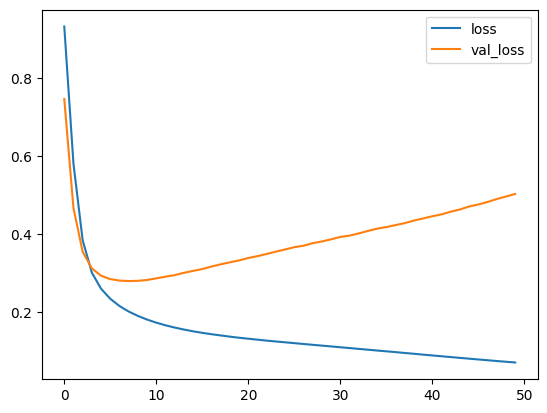

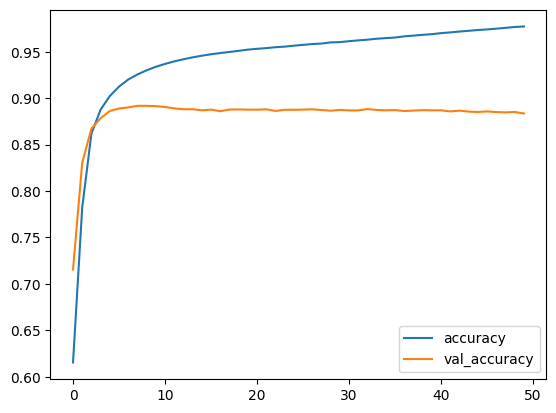

In [51]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Training Swivel

In [52]:
swivel_model = build_model(swivel_module, name='swivel')

In [53]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

2024-01-29 15:06:28.438654: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-01-29 15:06:28.438798: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-01-29 15:06:28.438920: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/50
 6/45 [===>..........................] - ETA: 1s - loss: 1.3215 - accuracy: 0.2789

2024-01-29 15:06:29.244461: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-01-29 15:06:29.244845: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-01-29 15:06:29.304649: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-01-29 15:06:29.305756: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-01-29 15:06:29.307789: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/swivel/train/plugins/profile/2024_01_29_15_06_29

2024-01-29 15:06:29.308908: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./text_models/swivel/train/plugins/profile/2024_01_29_15_06_29/instance-20240129-195108.trace.json.gz
2024-01-29 15:06:29.310641: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./text_models/swivel/train/plugin

45/45 [==============================] - 2s 26ms/step - loss: 1.0996 - accuracy: 0.4352 - val_loss: 0.9261 - val_accuracy: 0.5946
Epoch 2/50
45/45 [==============================] - 1s 21ms/step - loss: 0.8401 - accuracy: 0.6367 - val_loss: 0.7793 - val_accuracy: 0.6613
Epoch 3/50
45/45 [==============================] - 1s 21ms/step - loss: 0.7132 - accuracy: 0.7000 - val_loss: 0.6669 - val_accuracy: 0.7180
Epoch 4/50
45/45 [==============================] - 1s 21ms/step - loss: 0.6094 - accuracy: 0.7496 - val_loss: 0.5788 - val_accuracy: 0.7592
Epoch 5/50
45/45 [==============================] - 1s 21ms/step - loss: 0.5321 - accuracy: 0.7824 - val_loss: 0.5189 - val_accuracy: 0.7857
Epoch 6/50
45/45 [==============================] - 1s 21ms/step - loss: 0.4798 - accuracy: 0.8042 - val_loss: 0.4805 - val_accuracy: 0.8030
Epoch 7/50
45/45 [==============================] - 1s 21ms/step - loss: 0.4441 - accuracy: 0.8192 - val_loss: 0.4543 - val_accuracy: 0.8132
Epoch 8/50
45/45 [======

<AxesSubplot: >

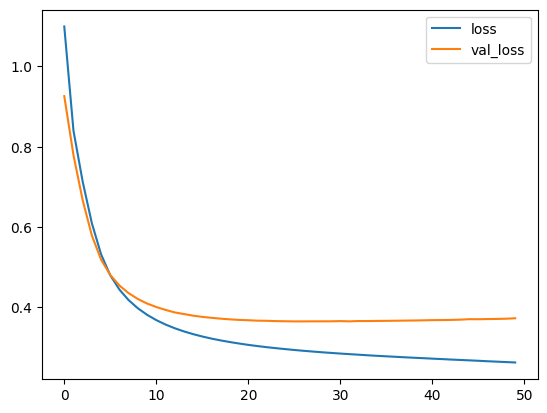

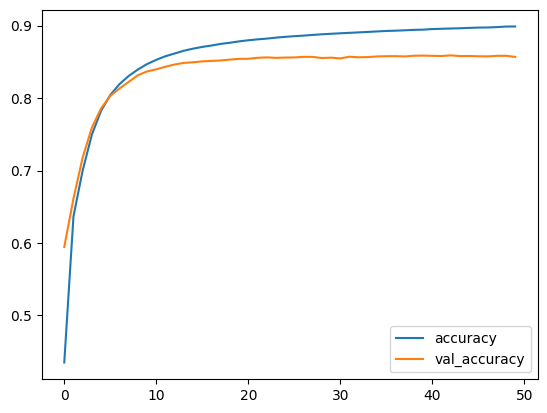

In [54]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

## Deploying the model

The first step is to serialize one of our trained Keras model as a SavedModel:

In [55]:
OUTPUT_DIR = "./savedmodels"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join(OUTPUT_DIR, 'swivel')
os.environ['EXPORT_PATH'] = EXPORT_PATH

shutil.rmtree(EXPORT_PATH, ignore_errors=True)

tf.saved_model.save(swivel_model, EXPORT_PATH)

2024-01-29 15:07:51.803702: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./savedmodels/swivel/assets


INFO:tensorflow:Assets written to: ./savedmodels/swivel/assets


Then we can deploy the model using the gcloud CLI as before:

### Lab Task 3a: Complete the following script to deploy the swivel model 

In [68]:
%%bash

# TODO 5

MODEL_NAME=title_model
VERSION_NAME=swivel

if [[ $(gcloud ai-platform models list --format='value(name)' | grep ^$MODEL_NAME$) ]]; then
    echo "$MODEL_NAME already exists"
else
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --region=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep ^$VERSION_NAME$) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    echo yes | gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create \
  --model=$MODEL_NAME $VERSION_NAME \
  --framework=tensorflow \
  --python-version=3.7 \
  --runtime-version=2.1 \
  --origin=$EXPORT_PATH \
  --staging-bucket=gs://$BUCKET \
  --machine-type n1-standard-4 \
  --region=$REGION

Using endpoint [https://us-central1-ml.googleapis.com/]


title_model already exists


Using endpoint [https://us-central1-ml.googleapis.com/]


Creating title_model:swivel


Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.versions.create) RESOURCE_EXHAUSTED: The requested number of n1-standard-4 exceeds the quota limit. Current usage/limit: 0/0, Requested: 8.


CalledProcessError: Command 'b'\n# TODO 5\n\nMODEL_NAME=title_model\nVERSION_NAME=swivel\n\nif [[ $(gcloud ai-platform models list --format=\'value(name)\' | grep ^$MODEL_NAME$) ]]; then\n    echo "$MODEL_NAME already exists"\nelse\n    echo "Creating $MODEL_NAME"\n    gcloud ai-platform models create --region=$REGION $MODEL_NAME\nfi\n\nif [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format=\'value(name)\' | grep ^$VERSION_NAME$) ]]; then\n    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "\n    echo yes | gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME\n    echo "Please run this cell again if you don\'t see a Creating message ... "\n    sleep 2\nfi\n\necho "Creating $MODEL_NAME:$VERSION_NAME"\ngcloud ai-platform versions create \\\n  --model=$MODEL_NAME $VERSION_NAME \\\n  --framework=tensorflow \\\n  --python-version=3.7 \\\n  --runtime-version=2.1 \\\n  --origin=$EXPORT_PATH \\\n  --staging-bucket=gs://$BUCKET \\\n  --machine-type n1-standard-4 \\\n  --region=$REGION\n'' returned non-zero exit status 1.

Before we try our deployed model, let's inspect its signature to know what to send to the deployed API:

In [ ]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}

Let's go ahead and hit our model:

### Lab Task 3b: Create the JSON object to send a title to the API  you just deployed
(**Hint:** Look at the 'saved_model_cli show' command output above.)

In [ ]:
%%writefile input.json
{"keras_layer_1_input":"Hello, this model is not Gemini"}

In [ ]:
!gcloud ai-platform predict \
  --model title_model \
  --json-instances input.json \
  --version swivel \
  --region=$REGION

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2023 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License